In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/RobbieHolland/AIWire.git
%cd AIWire
!ls

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!pip install h5py
import sys
sys.path.append("../") # go to parent dir
sys.path.append("../extract_centerline/")
sys.path.append("../extract_centerline/bin/")
sys.path.append("util/")
!ls

You should consider upgrading via the '/Users/Robert/Documents/venv/bin/python3.6 -m pip install --upgrade pip' command.
Classical_methods.py         classical_segmentation.ipynb
SegNet_segmentation.ipynb    dataset.py
Segnet_pytorch.py            load_data.py
UNet_segmentation.ipynb      testing_platform.ipynb
Unet_pytorch.py              util
__pycache__


In [3]:
# Import libraries 
import time
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import numpy as np
from tqdm.notebook import tqdm
import wireskeletonise 
from PIL import Image
import subprocess 
from centerline_extraction import * 
from util import show_images 

# Use full browser width
from IPython.core.display import display, HTML
display(HTML(""))

# (Option 1) Load data
Load data saved in a <tt>.mat</tt> file

In [4]:
from load_data import *
# X, y = load_data('/content/drive/My Drive/AIWIRE', 'dataset')
X, y, pts = load_data('.', '../data/dataset_all_1')

FileNotFoundError: [Errno 2] No such file or directory: './../data/dataset_all_1.mat'

In [5]:
import dataset
from sklearn.model_selection import train_test_split

batch_size = 5
test_length = round(y.shape[0] * 0.2)
pts = pts[:, :, ::-1]
X_train, y_train, X_test, y_test = X[:-test_length], y[:-test_length], X[-test_length:], y[-test_length:]
pts_train, pts_test = pts[:-test_length], pts[-test_length:]
dataloaders = dataset.gen_dataloaders(X_train, X_test, pts_train, y_train, y_test, pts_test, batch_size)

NameError: name 'y' is not defined

In [6]:
# Look at statistics of data
h2 = plt.hist(X_train[0].reshape(-1,1), bins = 100, density = True, alpha=1)

NameError: name 'X_train' is not defined

# Intensity-based Segmentation
Here, we use a Laplace filter to do a basic intensity based segmentation

In [7]:
# Segment data
from sklearn.mixture import GaussianMixture
import cv2
from Classical_methods import laplace_segmentation

# The background and the wire
n_components = 2

# model=GaussianMixture(n_components=n_components, means_init=[[0], [0.6]])
# model.fit(X, y)

In [8]:
%cd ../segmentation
original_dir= os.getcwd()
print(original_dir)

# Show first few segmentations
for i, (ground_truth, simulated, gt_pts) in enumerate(list(zip(y_test, X_test, pts_test))[:3]):
    centerline, cl_pts = get_centerline(laplace_segmentation(simulated),original_dir,'binary')
    show_images([ground_truth, simulated, simulated > 0.45, laplace_segmentation(simulated),centerline])

/Users/Robert/Documents/Kings/Group Project/AIWire/segmentation
/Users/Robert/Documents/Kings/Group Project/AIWire/segmentation


NameError: name 'y_test' is not defined

# (Option 2) Generate data
Run the Matlab engine to call scripts that generate data

In [9]:
# python -m ipykernel install --user --name=my-virtualenv-name
import matlab.engine
import pathlib
import os

# Show data
eng_start = time.time()
eng = matlab.engine.start_matlab()
print('Engine start took', time.time() - eng_start, 'seconds')

_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation'))
_ = eng.addpath(os.path.join(str(pathlib.Path().absolute().parents[0]), 'simulation/util'))

Engine start took 7.902791976928711 seconds


In [27]:

import cv2

data = []
n_samples = 1

blur = 1.3
im_size = eng.cell2mat([256.0, 192.0])
sim_start = time.time()
n_values = 10

blur_filter = eng.gen_blur_filter(float(250), float(1.3));
simulated_images = [[0 for x in range(n_values)] for y in range(n_samples)]
ground_truths = [[0 for x in range(n_values)] for y in range(n_samples)]
ground_truth_pts = [[0 for x in range(n_values)] for y in range(n_samples)]
laplace = [[0 for x in range(n_values)] for y in range(n_samples)]
laplace_old = [[0 for x in range(n_values)] for y in range(n_samples)]
smoothed = [[0 for x in range(n_values)] for y in range(n_samples)]

def_parameters = {}

# Change parameter to vary
def_parameters['Sigma'] = [0.1] * n_values
def_parameters['Undersampling factor'] = [0.9] * n_values
def_parameters['Undersampling spread'] = [0.9] * n_values
def_parameters['Tip current'] = [1.0] * n_values
def_parameters['Size anatomy'] = [0.5] * n_values
def_parameters['Ratio anatomy'] = [0.6] * n_values

# Example for 2 splines
parameters = def_parameters.copy()
parameters['Sigma'] = np.linspace(0, 0.5, num=n_values).tolist()
loop_prob = 1

for n in range(n_samples):
    seed = eng.rng('shuffle') 
    pts, _ = eng.gen_spline_realistic(im_size, 100.0, loop_prob, nargout = 2)
    gt_pts = np.array(pts._data).reshape(pts.size, order='F').T 
    gt_pts = gt_pts[:,1:]
    gt_pts[:,[0, 1]] = gt_pts[:,[1, 0]]   

    for i, (s, u, us, tc, sa, ra) in enumerate((np.array(list(parameters.values())).T.tolist())):
        eng.rng(seed)
        eng.rng(1238)
        ground_truth, simulated = np.array(eng.simulate(pts,im_size,blur_filter,1,0,0, 
                                                        eng.cell2mat([s, s]), 
                                                        eng.cell2mat([tc,tc]),
                                                        eng.cell2mat([u, u]),
                                                        eng.cell2mat([us,us]),
                                                        eng.cell2mat([sa,sa]),
                                                        eng.cell2mat([ra,ra]),nargout=2))
        simulated_images[n][i] = simulated
#         im, lp = laplace_segmentation(simulated, sigma = 6, threshold = 0.7)
        lp = laplace_segmentation(simulated, sigma = 7, threshold = 0.5)
        laplace[n][i] = lp
        
        lp = -cv2.Laplacian(simulated, cv2.CV_64F, ksize=10)
        lp = lp - np.min(lp)
        lp = lp / np.max(lp)
        lp = lp > 0.5
        laplace_old[n][i] = lp
#         smoothed[n][i] = im
        ground_truths[n][i] = ground_truth
        ground_truth_pts[n][i] = gt_pts
    show_images(simulated_images[n], height=13)
#     show_images(smoothed[n], height=13)
    show_images(laplace_old[n], height=13)
    show_images(laplace[n], height=13)

# Most of the time is to set up the connection
print('Simulation took', time.time() - sim_start, 'seconds')

error: OpenCV(4.1.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/deriv.cpp:104: error: (-211:One of the arguments' values is out of range) The kernel size must be odd and not larger than 31 in function 'getSobelKernels'


# Random Forest Segmentation
This is the first machine learning method we are using.


### Create the dataset
Random forests predict each patch of the image by taking as input a larger, surrounding patch (to capture context)<br>
Thus, <br>
<b>y</b>: Patches of the image <br>
<b>X</b>: Larger patches centered over each <b>y</b>

3315 2884


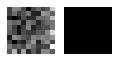

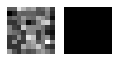

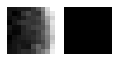

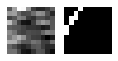

Filtered patches 10640
5
[5]


In [100]:
from random import randint

n_patches = 50000
patch_dim = 10
patches_sim, patches_gt = [], []
a, b = 0, 0
for i in range(n_patches):
    sample_train = X_train[i % len(X_train)]
    sample_test  = y_train[i % len(y_train)]
    tl = np.array([randint(0, sample_train.shape[i] - patch_dim - 1) for i in [0, 1]])
    gt = sample_test[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim]
    sim = sample_train[tl[0]:tl[0] + patch_dim, tl[1]:tl[1] + patch_dim]
    a += gt.sum() > 0
    b += gt.sum() == 0 and sim.sum() > 90
    if gt.sum() > 0 or sim.sum() > 70 or np.random.rand() < 0.03:
        patches_sim.append(sim)
        patches_gt.append(gt)
print(a, b)
for i, (patch_sim, patch_gt) in enumerate(list(zip(patches_sim, patches_gt))[:4]):
    show_images([patch_sim, patch_gt])
    
patches_sim, patches_gt = np.array(patches_sim), np.array(patches_gt)
n_patches = patches_sim.shape[0]
print(f'Filtered patches {n_patches}')
w = 0
c = patch_dim // 2
print(c)
print(list(range(c-w,c+w+1)))
patch_labels = np.array([p[c - w:c + w + 1, c - w:c + w + 1] for p in patches_gt])
X_patches = np.array(patches_sim).reshape(n_patches,-1)
y_patches = np.array(patch_labels).reshape(n_patches,-1)

### Train random forest classifier

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print('Class balance: ', np.sum(patch_labels) / np.prod(patch_labels.shape))
# clf = RandomForestClassifier(max_depth=100)

X_patches_train, X_patches_test, y_patches_train, y_patches_test = train_test_split(X_patches, y_patches, test_size=0.15, random_state=0)
print(X_patches_train.shape, X_patches_test.shape, y_patches_train.shape, y_patches_test.shape)

#clf = RandomForestClassifier(max_depth=100, class_weight = [{0: 1, 1:50}] * y_patches_train.shape[-1])
clf = RandomForestClassifier(max_depth=10)#, class_weight = {0: 1, 1:50})
clf.fit(X_patches_train, y_patches_train.astype(bool).ravel())
preds = clf.predict(X_patches_test)

Class balance:  0.028853383458646617
(9044, 100) (1596, 100) (9044, 1) (1596, 1)


/Users/Robert/Documents/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Make prediction on image
To actually segment an image, we must do so patch-by-patch<br>
Then collect the patches into the final segmentation

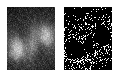

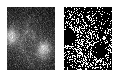

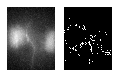

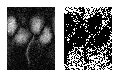

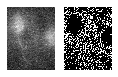

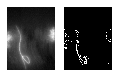

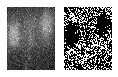

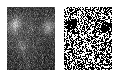

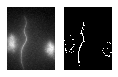

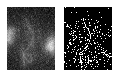

In [102]:
def rf_segmentation(image):
    test_sample = np.array(image)
    sample = np.pad(test_sample, patch_dim // 2 - w, mode='reflect')
    
    total_pred = np.zeros_like(test_sample)
    for i in range(w, test_sample.shape[0] - 2*w, 2 * w + 1):
        for j in range(w, test_sample.shape[1] - 2*w, 2 * w + 1):
            patch = sample[i:i + patch_dim, j:j + patch_dim]
            pred = clf.predict_proba(patch.reshape(1,-1))[0][1]
            total_pred[i-w:i+w+1,j-w:j+w+1] = pred.reshape(2 * w + 1, 2 * w + 1) > 0.1
    return total_pred

for i in range(10):
    pred = rf_segmentation(X[i])
    show_images([X[i], pred])